In [1]:
# What verion of python
from platform import python_version
print(python_version())

3.9.13


In [2]:
# Anaconda details
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/usr/local/anaconda3/bin/python
3.9.13 (main, Aug 25 2022, 18:29:29) 
[Clang 12.0.0 ]
sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)


In [3]:
# To run locally install the following packages
# !pip install numpy==1.19.5 pandas==1.3.5 ipywidgets==7.7.0 \
#             matplotlib==3.5.2 seaborn==0.11.2 wordcloud==1.8.1 \
#             scikit-learn==0.24.2 -q

As there are problems with installing they will be dealt with as needed.

### Data

#### Labeling

In this course, our data is already labeled, so we'll perform a basic version of ETL (extract, transform, load) to construct the labeled dataset. However, labeling can be a time intensive process so it's very important to understand all its different facets so that we can have efficient labeling workflows. 

Start by loading our data assets that we'll be working on.

 * [projects.csv](https://github.com/GokuMohandas/Made-With-ML/blob/main/datasets/projects.csv): projects with id, created time, title and description.
 * [tags.csv](https://github.com/GokuMohandas/Made-With-ML/blob/main/datasets/tags.csv): labels (tag category) for the projects by id.
 
**Objective** -  classify incoming content so that the community can discover them easily


#### Extract

Start by extracting data from our sources (external CSV files). Traditionally, our data assets will be stored, versioned and updated in a database, warehouse, etc. For now load our data as a stand-alone CSV file.

In [4]:
import pandas as pd

In [5]:
# Extract projects display the first 5
PROJECTS_URL = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/projects.csv"
projects = pd.read_csv(PROJECTS_URL)
projects.head(5)

,id,created_on,title,description
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla..."
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...


Load the labels (tag category) for our projects.

In [6]:
# Extract tags
TAGS_URL = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tags.csv"
tags = pd.read_csv(TAGS_URL)
tags.head(5)

,id,tag
0,6,computer-vision
1,7,computer-vision
2,9,graph-learning
3,15,reinforcement-learning
4,19,graph-learning


#### Transform

Apply basic transformations to create our labeled dataset.

In [7]:
# Join projects and tags
df = pd.merge(projects, tags, on="id")
df.head()

,id,created_on,title,description,tag
0,6,2020-02-20 06:43:18,Comparison between YOLO and RCNN on real world...,Bringing theory to experiment is cool. We can ...,computer-vision
1,7,2020-02-20 06:47:21,"Show, Infer & Tell: Contextual Inference for C...",The beauty of the work lies in the way it arch...,computer-vision
2,9,2020-02-24 16:24:45,Awesome Graph Classification,"A collection of important graph embedding, cla...",graph-learning
3,15,2020-02-28 23:55:26,Awesome Monte Carlo Tree Search,A curated list of Monte Carlo tree search pape...,reinforcement-learning
4,19,2020-03-03 13:54:31,Diffusion to Vector,Reference implementation of Diffusion2Vec (Com...,graph-learning


In [8]:
# Remove projects with no tag
df = df[df.tag.notnull()]

#### Load

Load our transformed data locally so that we can use it for our machine learning application.

In [9]:
# Save locally
df.to_csv("labeled_projects.csv", index=False)

### Exploration (EDA)

Using Exploratory data analysis to understand the signals and nuances of our dataset. It's a cyclical process that can be done at various points of our development process (before/after labeling, preprocessing, etc. depending on how well the problem is defined. For example, if we're unsure how to label or preprocess our data, we can use EDA to figure it out.

In [10]:
from collections import Counter
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from wordcloud import WordCloud, STOPWORDS
sns.set_theme()
warnings.filterwarnings("ignore")

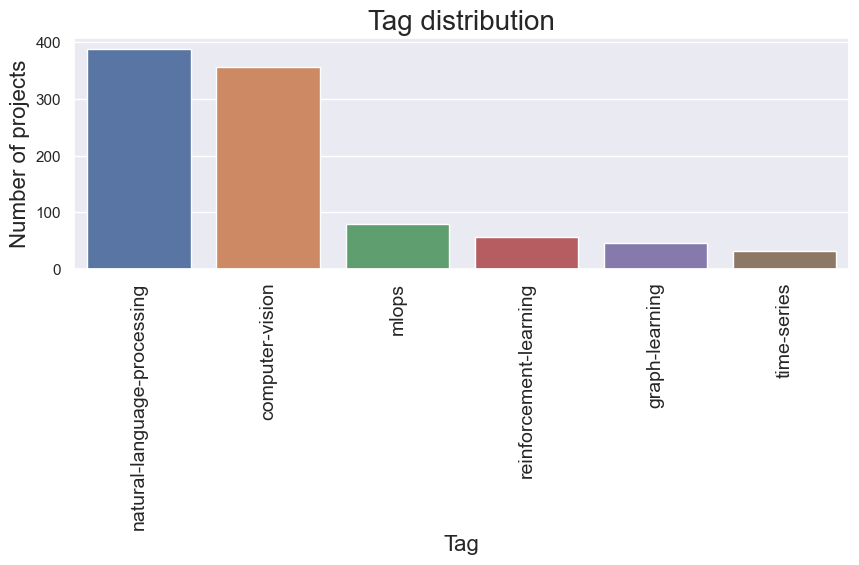

In [11]:
# Distribution of tags
tags, tag_counts = zip(*Counter(df.tag.values).most_common())
plt.figure(figsize=(10, 3))
ax = sns.barplot(x=list(tags), y=list(tag_counts))
plt.title("Tag distribution", fontsize=20)
plt.xlabel("Tag", fontsize=16)
ax.set_xticklabels(tags, rotation=90, fontsize=14)
plt.ylabel("Number of projects", fontsize=16)
plt.show()

In [ ]:
# Most common tags
tags = Counter(df.tag.values)
tags.most_common()

The data imbalance will be dealt with after splitting into the train split and prior to training our model.

In [ ]:
# Most frequent tokens for each tag
@widgets.interact(tag=list(tags))
def display_word_cloud(tag="natural-language-processing"):
    # Plot word clouds top top tags
    plt.figure(figsize=(15, 5))
    subset = df[df.tag==tag]
    text = subset.title.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300).generate(" ".join(text))
    plt.axis("off")
    plt.imshow(cloud)

Looks like the title text feature has some good signal for the respective classes and matches our intuition. We can repeat this for the description text feature as well. This _information_ will become useful when we decide how to use our features for modeling.

### Preprocessing

Preprocessing the data via feature engineering, filtering and cleaning. Certain preprocessing steps are global (don't depend on our dataset, ex. lower casing text, removing stop words, etc.) and others are local (constructs are learned only from the training split, ex. vocabulary, standardization, etc.). For the local, dataset-dependent preprocessing steps, we want to ensure that we split the data first before preprocessing to avoid data leaks.

#### Feature engineering

Combine existing input features to create new meaningful signal (helping the model learn).

In [ ]:
# Feature engineering
df["text"] = df.title + " " + df.description

#### Cleaning

Dealing with text data, apply some of the common text preprocessing steps:

In [ ]:
# !pip install nltk==3.7 -q

In [ ]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

In [ ]:
nltk.download("stopwords")
STOPWORDS = stopwords.words("english")
stemmer = PorterStemmer()

In [ ]:
def clean_text(text, lower=True, stem=False, stopwords=STOPWORDS):
    """Clean raw text."""
    # Lower
    if lower: 
        text = text.lower()

    # Remove stopwords
    if len(stopwords):
        pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
        text = pattern.sub('', text)

    # Spacing and filters
    text = re.sub(
        r"([!\"'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text
    )  # add spacing between objects to be filtered
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends

    # Remove links
    text = re.sub(r"http\S+", "", text)

    # Stemming
    if stem:
        text = " ".join([stemmer.stem(word, to_lowercase=lower) for word in text.split(" ")])

    return text

In [ ]:
# Toggle preprocessing parameters
@widgets.interact(lower=True, stem=False)
def display_cleaned_text(lower, stem):
    text = "Conditional image generation using Variational Autoencoders and GANs."
    cleaned_text = clean_text(text=text, lower=lower, stem=stem)
    print (cleaned_text)    

In [ ]:
# Apply to dataframe
original_df = df.copy()
df.text = df.text.apply(clean_text, lower=True, stem=False)
print (f"{original_df.text.values[0]}\n{df.text.values[0]}")

### Replace labels

Based on our findings from EDA, we're going to clean up our label space:

   * if a data point has a tag that we currently don't support, we'll replace it with **other**
   * if a certain tag doesn't have enough samples, we'll replace it with **other**

In [ ]:
# Accepted tags (external constraint)
ACCEPTED_TAGS = ["natural-language-processing", "computer-vision", "mlops", "graph-learning"]

In [ ]:
# Out of scope (OOS) tags
oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
oos_tags

In [ ]:
# Samples with OOS tags
oos_indices = df[df.tag.isin(oos_tags)].index
df[df.tag.isin(oos_tags)].head()

In [ ]:
# Replace this tag with `other`
df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)
df.iloc[oos_indices].head()

Going to restrict the mapping to only tags that are above a certain frequency threshold. 

The tags that don't have enough projects will not have enough samples to model their relationships.

In [ ]:
# Minimum frequency required for a tag
min_freq = 75
tags = Counter(df.tag.values)

In [ ]:
# Tags that just made / missed the cut
@widgets.interact(min_freq=(0, tags.most_common()[0][1]))
def separate_tags_by_freq(min_freq=min_freq):
    tags_above_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] >= min_freq)
    tags_below_freq = Counter(tag for tag in tags.elements()
                                    if tags[tag] < min_freq)
    print ("Most popular tags:\n", tags_above_freq.most_common(3))
    print ("\nTags that just made the cut:\n", tags_above_freq.most_common()[-3:])
    print ("\nTags that just missed the cut:\n", tags_below_freq.most_common(3))

In [ ]:
# Filter tags that have fewer than <min_freq> occurrences
tags_above_freq = Counter(tag for tag in tags.elements() 
                          if (tags[tag] >= min_freq))
df.tag = df.tag.apply(lambda tag: tag if tag in tags_above_freq else None)

In [ ]:
# Fill None with `other`
df.tag = df.tag.fillna("other")

Traditionally, we would be applying data quality tests on our data assets before and after labeling our data.

### Encoding

Start by encoding the labels into numerical values so our models can process them.

In [ ]:
import numpy as np
import random

In [ ]:
# Get data
X = df.text.to_numpy()
y = df.tag

Writing our own LabelEncoder which is based on scikit-learn's implementation.

In [ ]:
class LabelEncoder(object):
    """Encode labels into unique indices."""
    def __init__(self, class_to_index={}):
        self.class_to_index = class_to_index
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())

    def __len__(self):
        return len(self.class_to_index)

    def __str__(self):
        return f"<LabelEncoder(num_classes={len(self)})>"

    def fit(self, y):
        classes = np.unique(y)
        for i, class_ in enumerate(classes):
            self.class_to_index[class_] = i
        self.index_to_class = {v: k for k, v in self.class_to_index.items()}
        self.classes = list(self.class_to_index.keys())
        return self

    def encode(self, y):
        encoded = np.zeros((len(y)), dtype=int)
        for i, item in enumerate(y):
            encoded[i] = self.class_to_index[item]
        return encoded

    def decode(self, y):
        classes = []
        for i, item in enumerate(y):
            classes.append(self.index_to_class[item])
        return classes

    def save(self, fp):
        with open(fp, "w") as fp:
            contents = {"class_to_index": self.class_to_index}
            json.dump(contents, fp, indent=4, sort_keys=False)

    @classmethod
    def load(cls, fp):
        with open(fp, "r") as fp:
            kwargs = json.load(fp=fp)
        return cls(**kwargs)

In [ ]:
# Encode
label_encoder = LabelEncoder()
label_encoder.fit(y)
num_classes = len(label_encoder)

In [ ]:
label_encoder.class_to_index

In [ ]:
label_encoder.index_to_class

In [ ]:
# Encode
label_encoder.encode(["computer-vision", "mlops", "mlops"])

In [ ]:
# Decode
label_encoder.decode(np.array([0, 1, 1]))

In [ ]:
# Encode all our labels
y = label_encoder.encode(y)
print (y.shape)

Many of the transformations that is going to be done on our input text features are model specific. 

For example, the simple baselines we may do *label* encoding → *tf-idf* while for the more involved architectures we may do label encoding → *one-hot* encoding → *embeddings*. 

#### Splitting

It's time to split our dataset into three data splits for training, validation and testing.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Split sizes
train_size = 0.7
val_size = 0.15
test_size = 0.15

For our multi-class task (each input has one label), we want to ensure that each data split has similar class distributions. We can achieve this by specifying how to stratify the split by adding the **stratify** keyword argument.

In [ ]:
# Split (train)
X_train, X_, y_train, y_ = train_test_split(
    X, y, train_size=train_size, stratify=y)

In [ ]:
print (f"train: {len(X_train)} ({(len(X_train) / len(X)):.2f})\n"
       f"remaining: {len(X_)} ({(len(X_) / len(X)):.2f})")

In [ ]:
# Split (test)
X_val, X_test, y_val, y_test = train_test_split(
    X_, y_, train_size=0.5, stratify=y_)

In [ ]:
print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

In [ ]:
# Get counts for each class
counts = {}
counts["train_counts"] = {tag: label_encoder.decode(y_train).count(tag) for tag in label_encoder.classes}
counts["val_counts"] = {tag: label_encoder.decode(y_val).count(tag) for tag in label_encoder.classes}
counts["test_counts"] = {tag: label_encoder.decode(y_test).count(tag) for tag in label_encoder.classes}

In [ ]:
# View distributions
pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)

It's hard to compare these because our train and test proportions are different. Let's see what the distribution looks like once we balance it out. What do we need to multiply our test ratio by so that we have the same amount as our train ratio?

        alpha * N(test) = N(train)
        
        alpha = N(train)/N(test)

In [ ]:
# Adjust counts across splits
for k in counts["val_counts"].keys():
    counts["val_counts"][k] = int(counts["val_counts"][k] * \
        (train_size/val_size))
for k in counts["test_counts"].keys():
    counts["test_counts"][k] = int(counts["test_counts"][k] * \
        (train_size/test_size))

In [ ]:
dist_df = pd.DataFrame({
    "train": counts["train_counts"],
    "val": counts["val_counts"],
    "test": counts["test_counts"]
}).T.fillna(0)
dist_df

We can see how much deviance there is in our naive data splits by computing the standard deviation of each split's class counts from the mean (ideal split).


       σ  = √(x - x̄)2/ N

In [ ]:
# Standard deviation
np.mean(np.std(dist_df.to_numpy(), axis=0))

In [ ]:
# Split DataFrames
train_df = pd.DataFrame({"text": X_train, "tag": label_encoder.decode(y_train)})
val_df = pd.DataFrame({"text": X_val, "tag": label_encoder.decode(y_val)})
test_df = pd.DataFrame({"text": X_test, "tag": label_encoder.decode(y_test)})
train_df.head()

If we had a multi-label classification task, then we would've applied iterative stratification via the skmultilearn library, which essentially splits each input into subsets (where each label is considered individually) and then it distributes the samples starting with fewest "positive" samples and working up to the inputs that have the most labels.

__Stratified sampling is a sampling method that takes into account the existence of disjoint groups within a population and produces samples where the proportion of these groups is maintained. In single-label classification tasks, groups are differentiated based on the value of the target variable.__

In [ ]:
from skmultilearn.model_selection import IterativeStratification
def iterative_train_test_split(X, y, train_size):
    """Custom iterative train test split which 
    'maintains balanced representation with respect 
    to order-th label combinations.'
    """
    stratifier = IterativeStratification(
        n_splits=2, order=1, sample_distribution_per_fold=[1.0-train_size, train_size, ])
    train_indices, test_indices = next(stratifier.split(X, y))
    X_train, y_train = X[train_indices], y[train_indices]
    X_test, y_test = X[test_indices], y[test_indices]
    return X_train, X_test, y_train, y_test

Iterative stratification essentially creates splits while "trying to maintain balanced representation with respect to order-th label combinations". We used to an __order=1__ for our iterative split which means we cared about providing representative distribution of each tag across the splits. But we can account for higher-order label relationships as well where we may care about the distribution of label combinations.

#### Augmentation

We'll often want to increase the size and diversity of our training data split through data augmentation. It involves using the existing samples to generate synthetic, yet realistic, examples.

    It's important that we implement augmentation and data imbalance techniques after splitting our dataset so that we aren't introducing data leaks.

We'll use the nlpaug library to augment our dataset and assess the quality of the generated samples.

In [ ]:
# !pip install nlpaug==1.1.0 transformers==3.0.2 -q
# !pip install snorkel==0.9.8 -q

In [ ]:
# pip install nlpaug

In [ ]:
# conda install -c makcedward nlpaug

In [ ]:
# pip uninstall numpy
# pip install numpy

In [ ]:
# pip install --upgrade numpy

In [ ]:
import nlpaug.augmenter.word as naw

In [ ]:
# Load tokenizers and transformers
substitution = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="substitute")
insertion = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", action="insert")

In [ ]:
text = "Conditional image generation using Variational Autoencoders and GANs."

In [ ]:
# Substitutions
substitution.augment(text)

Substitution doesn't seem like a great idea for us because there are certain keywords that provide strong signal for our tags so we don't want to alter those. Also, note that these augmentations are NOT deterministic and will vary every time we run them. Let's try insertion...

In [ ]:
# Insertions
insertion.augment(text)

A little better but still quite fragile and now it can potentially insert key words that can influence false positive tags to appear. Maybe instead of substituting or inserting new tokens, let's try simply swapping machine learning related keywords with their aliases. We'll use Snorkel's transformation functions to easily achieve this.

In [ ]:
#!pip install snorkel

In [ ]:
# Replace dashes from tags & aliases
def replace_dash(x):
    return x.replace("-", " ")

In [ ]:
# Aliases
aliases_by_tag = {
    "computer-vision": ["cv", "vision"],
    "mlops": ["production"],
    "natural-language-processing": ["nlp", "nlproc"]
}

In [ ]:
# Flatten dict
flattened_aliases = {}
for tag, aliases in aliases_by_tag.items():
    tag = replace_dash(x=tag)
    if len(aliases):
        flattened_aliases[tag] = aliases
    for alias in aliases:
        _aliases = aliases + [tag]
        _aliases.remove(alias)
        flattened_aliases[alias] = _aliases

In [ ]:
print (flattened_aliases["natural language processing"])
print (flattened_aliases["nlp"])

For now we'll use tags and aliases as they are in *aliases_by_tag* but we could account for plurality of tags using the inflect package or apply stemming before replacing aliases, etc.

In [ ]:
# We want to match with the whole word only
print ("gan" in "This is a gan.")
print ("gan" in "This is gandalf.")

In [ ]:
# \b matches spaces
def find_word(word, text):
    word = word.replace("+", "\+")
    pattern = re.compile(fr"\b({word})\b", flags=re.IGNORECASE)
    return pattern.search(text)

In [ ]:
# Correct behavior (single instance)
print (find_word("gan", "This is a gan."))
print (find_word("gan", "This is gandalf."))

Now let's use snorkel's **transformation_function** to systematically apply this transformation to our data.

In [ ]:
from snorkel.augmentation import transformation_function

In [ ]:
@transformation_function()
def swap_aliases(x):
    """Swap ML keywords with their aliases.""" 
    # Find all matches
    matches = []
    for i, tag in enumerate(flattened_aliases):
        match = find_word(tag, x.text)  
        if match:
            matches.append(match)
    # Swap a random match with a random alias
    if len(matches):
        match = random.choice(matches)
        tag = x.text[match.start():match.end()]
        x.text = f"{x.text[:match.start()]}{random.choice(flattened_aliases[tag])}{x.text[match.end():]}"
    return x

In [ ]:
# Swap
for i in range(3):
    sample_df = pd.DataFrame([{"text": "a survey of reinforcement learning for nlp tasks."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

In [ ]:
# Undesired behavior (needs contextual insight)
for i in range(3):
    sample_df = pd.DataFrame([{"text": "Autogenerate your CV to apply for jobs using NLP."}])
    sample_df.text = sample_df.text.apply(clean_text, lower=True, stem=False)
    print (swap_aliases(sample_df.iloc[0]).text)

Define a augmentation policy to apply our transformation functions with certain rules 

(how many samples to generate, whether to keep the original data point, etc.)

In [ ]:
from snorkel.augmentation import ApplyOnePolicy, PandasTFApplier

In [ ]:
# Transformation function (TF) policy
policy = ApplyOnePolicy(n_per_original=5, keep_original=True)
tf_applier = PandasTFApplier([swap_aliases], policy)
train_df_augmented = tf_applier.apply(train_df)
train_df_augmented.drop_duplicates(subset=["text"], inplace=True)
train_df_augmented.head()

In [ ]:
len(train_df), len(train_df_augmented)

For now, we'll skip the data augmentation because it's quite fickle and empirically it doesn't improvement performance much. But we can see how this can be very effective once we can control what type of vocabulary to augment on and what exactly to augment with.

    Regardless of what method we use, it's important to validate that we're not just augmenting for the sake of
    augmentation. We can do this by executing any existing data validation tests and even creating specific tests 
    to apply on augmented data.

#### Modeling

We'll begin modeling by starting with the simplest baseline and slowly adding complexity.

    The specific model we use is irrelevant since the main focus is on all the components required 
    to put a model in production and maintain it. 
    
We'll first set up some functions that we'll be using across the different baseline experiments.

In [ ]:
import random

In [ ]:
def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)

In [ ]:
def preprocess(df, lower, stem, min_freq):
    """Preprocess the data."""
    df["text"] = df.title + " " + df.description  # feature engineering
    df.text = df.text.apply(clean_text, lower=lower, stem=stem)  # clean text

    # Replace OOS tags with `other`
    oos_tags = [item for item in df.tag.unique() if item not in ACCEPTED_TAGS]
    df.tag = df.tag.apply(lambda x: "other" if x in oos_tags else x)

    # Replace tags below min_freq with `other`
    tags = Counter(df.tag.values)
    tags_above_freq = Counter(tag for tag in tags.elements() 
                            if (tags[tag] >= min_freq))
    df.tag = df.tag.apply(lambda tag: tag if tag in tags_above_freq else None)
    df.tag = df.tag.fillna("other")

    return df

In [ ]:
def get_data_splits(X, y, train_size=0.7):
    """Generate balanced data splits."""
    X_train, X_, y_train, y_ = train_test_split(
        X, y, train_size=train_size, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(
        X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test

Our dataset is small so we'll train using the whole dataset but for larger datasets, we should always test on a small subset (after shuffling when necessary) so we aren't wasting time on compute.

    **df = df.sample(frac=1).reset_index(drop=True)  # shuffle**
    **df = df[: num_samples]  # None = all samples**

**Why is it important that we shuffle our data?**

We need to shuffle our data since our data is chronologically organized. The latest projects may have certain features or tags that are prevalent compared to earlier projects. If we don't shuffle before creating our data splits, then our model will only be trained on the earlier signals and fail to generalize. However, in other scenarios (ex. time-series forecasting), shuffling will lead do data leaks.

### Baselines
We're going to develop a model that can consume input signals and predict the appropriate classes. We'll start with simple baseline models and slowly add and motivate complexity.

#### Random

_motivation_: We want to know what random (chance) performance looks like. All of our efforts should be well above this baseline.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# Set up
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))


In [ ]:
# Label encoder
print (label_encoder)
print (label_encoder.classes)

In [ ]:
# Generate random predictions
y_pred = np.random.randint(low=0, high=len(label_encoder), size=len(y_test))
print (y_pred.shape)
print (y_pred[0:5])

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

We made the assumption that there is an equal probability for every class. Let's use the train split to figure out what the true probability is.

In [ ]:
# Class frequencies
p = [Counter(y_test)[index]/len(y_test) for index in range(len(label_encoder))]

p

In [ ]:
# Generate weighted random predictions
y_pred = np.random.choice(a=range(len(label_encoder)), size=len(y_test), p=p)

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

limitations: we didn't use the tokens in our input to affect our predictions so nothing was learned.

#### Rule-based

motivation: we want to use signals in our inputs (along with domain expertise and auxiliary data) to determine the labels.

In [ ]:
# Setup
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

In [ ]:
def get_tag(text, aliases_by_tag):
    """If a token matches an alias, 
    then add the corresponding tag class."""
    for tag, aliases in aliases_by_tag.items():
        if replace_dash(tag) in text:
            return tag
        for alias in aliases:
            if alias in text:
                return tag
    return None

In [ ]:
# Sample
text = "A pretrained model hub for popular nlp models."
get_tag(text=clean_text(text), aliases_by_tag=aliases_by_tag)

In [ ]:
# Prediction
tags = []
for text in X_test:
    tag = get_tag(text, aliases_by_tag=aliases_by_tag)
    tags.append(tag)

In [ ]:
# Encode labels
y_pred = [label_encoder.class_to_index[tag] if tag is not None else -1 for tag in tags]

In [ ]:
# Evaluate
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

**Why is recall so low?** 

Only relying on the aliases can prove catastrophic when those particular aliases aren't used in our input signals. 

To improve this, we can build a bag of words of related terms. 

For example, mapping terms such as _text classification_ and named _entity recognition_ to the _natural-language-processing_ tag but building this is a non-trivial task. 

Not to mention, we'll need to keep updating these rules as the data landscape matures.

In [ ]:
# Pitfalls
text = "Transfer learning with transformers for text classification."
print (get_tag(text=clean_text(text), aliases_by_tag=aliases_by_tag))

We could also use stemming to further refine our rule-based process:

        from nltk.stem import PorterStemmer
        stemmer = PorterStemmer()
        print (stemmer.stem("democracy"))
        print (stemmer.stem("democracies"))
        democraci
        democraci

But these rule-based approaches can only yield labels with high certainty when there is an absolute condition match so it's best not to spend too much more effort on this approach.

limitations: we failed to generalize or learn any implicit patterns to predict the labels because we treat the tokens in our input as isolated entities.



#### Vectorization

_motivation_:

    representation: use term frequency-inverse document frequency (TF-IDF) to capture the significance of a token to a particular input with respect to all the inputs, as opposed to treating the words in our input text as isolated tokens.
    
    architecture: we want our model to meaningfully extract the encoded signal to predict the output labels.

So far we've treated the words in our input text as isolated tokens and we haven't really captured any meaning between tokens. Let's use TF-IDF (via scikit-learn's TfidfVectorizer) to capture the significance of a token to a particular input with respect to all the inputs.



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# Setup
set_seeds()
df = pd.read_csv("labeled_projects.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
label_encoder = LabelEncoder().fit(df.tag)
X_train, X_val, X_test, y_train, y_val, y_test = \
    get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

In [ ]:
# Saving raw X_test to compare with later
X_test_raw = X_test

In [ ]:
# Tf-idf
vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,7))  # char n-grams
print (X_train[0])
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)
print (X_train.shape)  # scipy.sparse.csr_matrix

In [ ]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

#### Data imbalance

With our datasets, we may often notice a data imbalance problem where a range of continuous values (regression) or certain classes (classification) may have insufficient amounts of data to learn from. This becomes a major issue when training because the model will learn to generalize to the data available and perform poorly on regions where the data is sparse. There are several techniques to mitigate data imbalance, including resampling, incorporating class weights, augmentation, etc. Though the ideal solution is to collect more data for the minority classes!

    use the imblearn package to ensure that we oversample our minority classes to be equal to the majority class 
    (tag with most samples).

In [ ]:
# !pip install imbalanced-learn==0.8.1 -q

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Oversample (training set)
oversample = RandomOverSampler(sampling_strategy="all")
X_over, y_over = oversample.fit_resample(X_train, y_train)

It's important that we applied sampling only on the train split so we don't introduce data leaks with the other data splits.

In [ ]:
# Class weights
counts = np.bincount(y_over)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

#### Machine learning

Use a stochastic gradient descent classifier (SGDClassifier) as our model. We're going to use log loss so that it's effectively logistic regression with SGD.

    We're doing this because we want to have more control over the training process (epochs) 
    and not use scikit-learn's default second order optimization methods 
    (ex. LGBFS) for logistic regression.

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, precision_recall_fscore_support

In [ ]:
# Initialize model
model = SGDClassifier(
    loss="log", penalty="l2", alpha=1e-4, max_iter=1,
    learning_rate="constant", eta0=1e-1, power_t=0.1, 
    warm_start=True)

In [ ]:
# Train model
num_epochs = 100
for epoch in range(num_epochs):
    # Training
    model.fit(X_over, y_over)

    # Evaluation
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    val_loss = log_loss(y_val, model.predict_proba(X_val))

    if not epoch%10:
        print(
            f"Epoch: {epoch:02d} | "
            f"train_loss: {train_loss:.5f}, "
            f"val_loss: {val_loss:.5f}"
        )

We could further optimize our training pipeline with functionality such as early stopping where we would use our validation set that we created. But we want to keep this model-agnostic course simplified during the modeling stage.

    The SGDClassifier has an _early_stopping_ flag where you can specify a portion of the training 
    set to be use for validation. Why would this be a bad idea in our case? 
    Because we already applied oversampling in our training set and so we would be 
    introduce data leaks if we did this.

In [ ]:
# Evaluate
y_pred = model.predict(X_test)
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

Scikit-learn has a concept called pipeline which allows us to combine transformations and training steps into one callable function.

We can create a pipeline from scratch:

    '# Create pipeline from scratch'
    from sklearn.pipeline import Pipeline
    steps = (
        ("tfidf", TfidfVectorizer(analyzer="char", ngram_range=(2,7))), 
        ("model", SGDClassifier(
            loss="log", penalty="l2", alpha=1e-4, max_iter=1,
            learning_rate="constant", eta0=1e-1, power_t=0.1, 
            warm_start=True)))
    pipe = Pipeline(steps)
    pipe.fit(X_train, y_train)
    
or make one with trained components:

    '# Make pipeline from existing components'
    from sklearn.pipeline import make_pipeline
    pipe = make_pipeline(vectorizer, model)

limitations:

    representation: TF-IDF representations don't encapsulate much signal beyond frequency 
    but we require more fine-grained token representations that can account for 
    the significance of the token itself (embeddings).

    architecture: we want to develop models that can use better represented encodings 
    in a more contextual manner.

In [ ]:
# Inference (with tokens similar to training data)
text = "Transfer learning with transformers for text classification."
y_pred = model.predict(vectorizer.transform([text]))
label_encoder.decode(y_pred)

In [ ]:
# Probabilities
y_prob = model.predict_proba(vectorizer.transform([text]))
{tag:y_prob[0][i] for i, tag in enumerate(label_encoder.classes)}

In [ ]:
# Inference (with tokens not similar to training data)
text = "Interpretability methods for explaining model behavior."
y_pred = model.predict(vectorizer.transform([text]))
label_encoder.decode(y_pred)

In [ ]:
# Probabilities
y_prob = model.predict_proba(vectorizer.transform([text]))
{tag:y_prob[0][i] for i, tag in enumerate(label_encoder.classes)}

We're going to create a custom predict function where if the majority class is not above a certain softmax score, then we predict the _other_ class. In our objectives, we decided that precision is really important for us and that we can leverage the labeling and QA workflows to improve the recall during subsequent manual inspection.

Our models can suffer from overconfidence so applying this limitation may not be as effective as we'd imagine, especially for larger neural networks. See the confident learning section of the evaluation lesson for more information.

In [ ]:
# Determine first quantile softmax score for the correct class (on validation split)
y_pred = model.predict(X_val)
y_prob = model.predict_proba(X_val)
threshold = np.quantile([y_prob[i][j] for i, j in enumerate(y_pred)], q=0.25)  # Q1
threshold

It's very important that we do this on our validation split so we aren't inflating the value using the train split or leaking information prior to evaluation on the test split.

In [ ]:
# Custom predict function
def custom_predict(y_prob, threshold, index):
    """Custom predict function that defaults 
    to an index if conditions are not met."""
    y_pred = [np.argmax(p) if max(p) > threshold else index for p in y_prob]
    return np.array(y_pred)

In [ ]:
def predict_tag(texts):
    y_prob = model.predict_proba(vectorizer.transform(texts))
    other_index = label_encoder.class_to_index["other"]
    y_pred = custom_predict(y_prob=y_prob, threshold=threshold, index=other_index)
    return label_encoder.decode(y_pred)


In [ ]:
# Inference (with tokens not similar to training data)
text = "Interpretability methods for explaining model behavior."
predict_tag(texts=[text])

In [ ]:
# Evaluate
y_prob = model.predict_proba(X_test)
y_pred = custom_predict(y_prob=y_prob, threshold=threshold, index=label_encoder.class_to_index["other"])
metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
print (json.dumps(performance, indent=2))

We could've even used per-class thresholds, especially since we have some data imbalance which can impact how confident the model is regarding some classes.

    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)
    class_thresholds = {}
    for index in range(len(label_encoder.classes)):
        class_thresholds[index] = np.mean(
            [y_prob[i][index] for i in np.where(y_pred==index)[0]])

**Note**: 
This is actually model-agnostic (as long as it produces probability distributions) so feel free to use more complex representations (embeddings) with more sophisticated architectures (CNNs, transformers, etc.). 

We're going to use this basic logistic regression model throughout the rest of the lessons because it's easy, fast and actually has comparable performance (<10% f1 diff compared to SOTA pretrained transformers).

#### Evaluation

So far we've been evaluating our models by determing the overall precision, recall and f1 scores. But since performance is one of the key decision making factors when comparing different models, we should have even more nuanced evaluation strategies.

    * Coarse-grained metrics
    * Fine-grained metrics
    * Confusion matrix
    * Confidence learning
    * Slice metrics

In [ ]:
# Metrics
metrics = {"overall": {}, "class": {}}

In [ ]:
# Data to evaluate
other_index = label_encoder.class_to_index["other"]
y_prob = model.predict_proba(X_test)
y_pred = custom_predict(y_prob=y_prob, threshold=threshold, index=other_index)

#### Coarse-grained metrics

In [ ]:
# Overall metrics
overall_metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
metrics["overall"]["precision"] = overall_metrics[0]
metrics["overall"]["recall"] = overall_metrics[1]
metrics["overall"]["f1"] = overall_metrics[2]
metrics["overall"]["num_samples"] = np.float64(len(y_test))
print (json.dumps(metrics["overall"], indent=4))

#### Fine-grained metrics

In [ ]:
from collections import OrderedDict

In [ ]:
# Per-class metrics
class_metrics = precision_recall_fscore_support(y_test, y_pred, average=None)
for i, _class in enumerate(label_encoder.classes):
    metrics["class"][_class] = {
        "precision": class_metrics[0][i],
        "recall": class_metrics[1][i],
        "f1": class_metrics[2][i],
        "num_samples": np.float64(class_metrics[3][i]),
    }

In [ ]:
# Metrics for a specific class
tag = "natural-language-processing"
print (json.dumps(metrics["class"][tag], indent=2))

In [ ]:
# Sorted tags
sorted_tags_by_f1 = OrderedDict(sorted(
        metrics["class"].items(), key=lambda tag: tag[1]["f1"], reverse=True))
for item in sorted_tags_by_f1.items():
    print (json.dumps(item, indent=2))

Due to our custom predict function, we're able to achieve high precision for the categories except for other. 

Based on our product design, we decided that it's more important to be precise about our explicit ML categories (nlp, cv, and mlops) and that we would have a manual labeling workflow to recall any misclassifications in the other category. 

Overtime, our model will become better in this category as well.

#### Confusion matrix

**True positives (TP)**: learn about where our model performs well.

**False positives (FP)**: potentially identify samples which may need to be relabeled.

**False negatives (FN)**: identify the model's less performant areas to oversample later.

It's a good to have our FP/FN samples feed back into our annotation pipelines in the event we want to fix their labels and have those changes be reflected everywhere.

In [ ]:
# TP, FP, FN samples
tag = "mlops"
index = label_encoder.class_to_index[tag]
tp, fp, fn = [], [], []
for i, true in enumerate(y_test):
    pred = y_pred[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)

In [ ]:
print (tp)
print (fp)
print (fn)

In [ ]:
index = tp[0]
print (X_test_raw[index])
print (f"true: {label_encoder.decode([y_test[index]])[0]}")
print (f"pred: {label_encoder.decode([y_pred[index]])[0]}")

In [ ]:
@widgets.interact(tag=list(sorted_tags_by_f1.keys()))
def display_tag_analysis(tag="mlops"):
    # Performance
    print (json.dumps(metrics["class"][tag], indent=2))

    # TP, FP, FN samples
    index = label_encoder.class_to_index[tag]
    tp, fp, fn = [], [], []
    for i, true in enumerate(y_test):
        pred = y_pred[i]
        if index==true==pred:
            tp.append(i)
        elif index!=true and index==pred:
            fp.append(i)
        elif index==true and index!=pred:
            fn.append(i)

    # Samples
    num_samples = 3
    cm = [(tp, "True positives"), (fp, "False positives"), (fn, "False negatives")]
    for item in cm:
        if len(item[0]):
            print (f"\n=== {item[1]} ===")
            for index in item[0][:num_samples]:
                print (f"  {X_test_raw[index]}")
                print (f"    true: {label_encoder.decode([y_test[index]])[0]}")
                print (f"    pred: {label_encoder.decode([y_pred[index]])[0]}\n")

It's a really good idea to do this kind of analysis using our rule-based approach to catch really obvious labeling errors.

### Confidence learning

While the confusion-matrix sample analysis was a coarse-grained process, we can also use fine-grained confidence based approaches to identify potentially mislabeled samples. Here we’re going to focus on the specific labeling quality as opposed to the final model predictions.

Simple confidence based techniques include identifying samples whose:

#### Categorical

    prediction is incorrect (also indicate TN, FP, FN)
    confidence score for the correct class is below a threshold
    confidence score for an incorrect class is above a threshold
    standard deviation of confidence scores over top N samples is low
    different predictions from same model using different parameters

#### Continuous

    difference between predicted and ground-truth values is above some %
    

The operations in this section can be applied to entire labeled dataset to discover labeling errors via confidence learning.

In [ ]:
# y
y_prob = model.predict_proba(X_test)
print (np.shape(y_test))
print (np.shape(y_prob))

In [ ]:
# Used to show raw text
test_df = pd.DataFrame({"text": X_test_raw, "tag": label_encoder.decode(y_test)})

In [ ]:
# Tag to inspect
tag = "mlops"
index = label_encoder.class_to_index[tag]
indices = np.where(y_test==index)[0]

In [ ]:
# Confidence score for the correct class is below a threshold
low_confidence = []
min_threshold = 0.5
for i in indices:
    prob = y_prob[i][index]
    if prob <= 0.5:
        low_confidence.append({"text": test_df.text[i], 
                               "true": label_encoder.index_to_class[y_test[i]], 
                               "pred": label_encoder.index_to_class[y_pred[i]], 
                               "prob": prob})

In [ ]:
low_confidence[0:5]

But these are fairly crude techniques because neural networks are easily overconfident and so their confidences cannot be used without calibrating them.

Modern (large) neural networks result in higher accuracies but are over confident.
On Calibration of Modern Neural Networks

   **Assumption**: “the probability associated with the predicted class label should reflect its ground truth correctness likelihood.”

   **Reality**: “modern (large) neural networks are no longer well-calibrated”

   **Solution**: apply temperature scaling (extension of Platt scaling{:target="_blank"}) on model outputs

Recent work on confident learning focuses on identifying noisy labels while accounting for this overconfidence which can then be properly relabeled and used for training.

In [ ]:
# !pip install cleanlab==1.0.1 -q

In [ ]:
import cleanlab
from cleanlab.pruning import get_noise_indices

In [ ]:
# Determine potential labeling errors
label_error_indices = get_noise_indices(
            s=y_test, 
            psx=y_prob,
            sorted_index_method="self_confidence",
            verbose=0)

Not all of these are necessarily labeling errors but situations where the predicted probabilities were not so confident. Therefore, it will be useful to attach the predicted outcomes along side results. This way, we can know if we need to relabel, upsample, etc. as mitigation strategies to improve our performance.

In [ ]:
num_samples = 5
for index in label_error_indices[:num_samples]:
    print ("text:", test_df.iloc[index].text)
    print ("true:", test_df.iloc[index].tag)
    print ("pred:", label_encoder.decode([y_pred[index]])[0])
    print ()

#### Slice metrics

Just inspecting the overall and class metrics isn't enough to deploy our new version to production. There may be key slices of our dataset that we need to do really well on:

    Target / predicted classes (+ combinations)
    Features (explicit and implicit)
    Metadata (timestamps, sources, etc.)
    Priority slices / experience (minority groups, large customers, etc.)

An easy way to create and evaluate slices is to define slicing functions.

In [ ]:
!pip install snorkel==0.9.8 -q

In [ ]:
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [ ]:
@slicing_function()
def nlp_cnn(x):
    """NLP Projects that use convolution."""
    nlp_projects = "natural-language-processing" in x.tag
    convolution_projects = "CNN" in x.text or "convolution" in x.text
    return (nlp_projects and convolution_projects)

In [ ]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.text.split()) < 8  # less than 8 words

Here we're using Snorkel's _slicing_function_ to create our different slices. We can visualize our slices by applying this slicing function to a relevant DataFrame using _slice_dataframe_.

In [ ]:
nlp_cnn_df = slice_dataframe(test_df, nlp_cnn)
nlp_cnn_df[["text", "tag"]].head()

In [ ]:
short_text_df = slice_dataframe(test_df, short_text)
short_text_df[["text", "tag"]].head()

We can define even more slicing functions and create a slices record array using the _PandasSFApplier_. The slices array has N (# of data points) items and each item has S (# of slicing functions) items, indicating whether that data point is part of that slice. Think of this record array as a masking layer for each slicing function on our data.

In [ ]:
# Slices
slicing_functions = [nlp_cnn, short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

To calculate metrics for our slices, we could use snorkel.analysis.Scorer but we've implemented a version that will work for multiclass or multilabel scenarios.

In [ ]:
# Score slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):  
        slice_metrics = precision_recall_fscore_support(
            y_test[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_test[mask])

In [ ]:
print(json.dumps(metrics["slices"], indent=2))

Slicing can help identify sources of bias in our data. For example, our model has most likely learned to associated algorithms with certain applications such as CNNs used for computer vision or transformers used for NLP projects. However, these algorithms are not being applied beyond their initial use cases. We’d need ensure that our model learns to focus on the application over algorithm. This could be learned with:

    enough data (new or oversampling incorrect predictions)
    masking the algorithm (using text matching heuristics).

#### Interpretability

Besides just comparing predicted outputs with ground truth values, we can also inspect the inputs to our models. What aspects of the input are more influential towards the prediction? If the focus is not on the relevant features of our input, then we need to explore if there is a hidden pattern we're missing or if our model has learned to overfit on the incorrect features. We can use techniques such as SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations) to inspect feature importance. On a high level, these techniques learn which features have the most signal by assessing the performance in their absence. These inspections can be performed on a global level (ex. per-class) or on a local level (ex. single prediction).

In [ ]:
!pip install lime==0.2.0.1 -q

In [ ]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

It's easier to use LIME with scikit-learn pipelines so we'll combine our vectorizer and model into one construct.

In [ ]:
# Create pipeline
pipe = make_pipeline(vectorizer, model)

In [ ]:
# Explain instance
text = "Using pretrained convolutional neural networks for object detection."
explainer = LimeTextExplainer(class_names=label_encoder.classes)
explainer.explain_instance(text, classifier_fn=pipe.predict_proba, top_labels=1).show_in_notebook(text=True)

Can also use model-specific approaches to interpretability we we did in our embeddings lesson to identify the most influential n-grams in our text.

#### Behavioral testing

In [ ]:
# INVariance via verb injection (changes should not affect outputs)
tokens = ["revolutionized", "disrupted"]
texts = [f"Transformers applied to NLP have {token} the ML field." for token in tokens]
predict_tag(texts=texts)

In [ ]:
# DIRectional expectations (changes with known outputs)
tokens = ["text classification", "image classification"]
texts = [f"ML applied to {token}." for token in tokens]
predict_tag(texts=texts)

In [ ]:
# Minimum Functionality Tests (simple input/output pairs)
tokens = ["natural language processing", "mlops"]
texts = [f"{token} is the next big wave in machine learning." for token in tokens]
predict_tag(texts=texts)

We'll learn how to systematically create tests in our testing lesson.

#### Experiment tracking

So far, we've been training and evaluating our different baselines but haven't really been tracking these experiments. We'll fix this but defining a proper process for experiment tracking which we'll use for all future experiments (including hyperparameter optimization). Experiment tracking is the processing of managing all the different experiments and their components, such as parameters, metrics, models and other artifacts and it enables us to:

    Organize all the necessary components of a specific experiment. It's important to have everything in one place and know where it is so you can use them later.
    
    Reproduce past results (easily) using saved experiments.
    
    Log iterative improvements across time, data, ideas, teams, etc.
    

There are many options for experiment tracking but we're going to use MLFlow (100% free and open-source) because it has all the functionality we'll need (and growing integration support). We can run MLFlow on our own servers and databases so there are no storage cost / limitations, making it one of the most popular options and is used by Microsoft, Facebook, Databricks and others. You can also set up your own Tracking servers to synchronize runs amongst multiple team members collaborating on the same task.


There are also several popular options such as a Comet ML (Used by Google AI, HuggingFace, etc.) and Weights and Biases (Used by Open AI, Toyota Research, etc.). These are fantastic tools that provide features like dashboards, seamless integration, hyperparameter search, reports and even debugging!

In [ ]:
!pip install mlflow==1.13.1 -q

In [ ]:
from argparse import Namespace
import mlflow
from pathlib import Path

The input argument _args_ contains all the parameters needed and it's nice to have it all organized under one variable so we can easily log it and tweak it for different experiments.

In [ ]:
# Specify arguments
args = Namespace(
    lower=True,
    stem=False,
    analyzer="char",
    ngram_max_range=7,
    alpha=1e-4,
    learning_rate=1e-1,
    power_t=0.1,
    num_epochs=100
)

In [ ]:
# Set tracking URI
MODEL_REGISTRY = Path("experiments")
Path(MODEL_REGISTRY).mkdir(exist_ok=True) # create experiments dir
mlflow.set_tracking_uri("file://" + str(MODEL_REGISTRY.absolute()))

In [ ]:
!ls

When we're collaborating with other team members, this model registry will live on the cloud. Members from our team can connect to it (with authentication) to save and load trained models. If you don't want to set up and maintain a model registry, this is where platforms like Comet ML, Weights and Biases and others offload a lot of technical setup.

#### Training

And to make things simple, we'll encapsulate all the components for training into one function which returns all the artifacts we want to be able to track from our experiment.

    Ignore the trial argument for now (default is None) 

In [ ]:
def train(args, df, trial=None):
    """Train model on data."""

    # Setup
    set_seeds()
    df = pd.read_csv("labeled_projects.csv")
    df = df.sample(frac=1).reset_index(drop=True)
    df = preprocess(df, lower=True, stem=False, min_freq=min_freq)
    label_encoder = LabelEncoder().fit(df.tag)
    X_train, X_val, X_test, y_train, y_val, y_test = \
        get_data_splits(X=df.text.to_numpy(), y=label_encoder.encode(df.tag))

    # Tf-idf
    vectorizer = TfidfVectorizer(analyzer=args.analyzer, ngram_range=(2,args.ngram_max_range))  # char n-grams
    X_train = vectorizer.fit_transform(X_train)
    X_val = vectorizer.transform(X_val)
    X_test = vectorizer.transform(X_test)

    # Oversample
    oversample = RandomOverSampler(sampling_strategy="all")
    X_over, y_over = oversample.fit_resample(X_train, y_train)

    # Model
    model = SGDClassifier(
        loss="log", penalty="l2", alpha=args.alpha, max_iter=1,
        learning_rate="constant", eta0=args.learning_rate, power_t=args.power_t, 
        warm_start=True)

    # Training
    for epoch in range(args.num_epochs):
        model.fit(X_over, y_over)
        train_loss = log_loss(y_train, model.predict_proba(X_train))
        val_loss = log_loss(y_val, model.predict_proba(X_val))
        if not epoch%10:
            print(
                f"Epoch: {epoch:02d} | "
                f"train_loss: {train_loss:.5f}, "
                f"val_loss: {val_loss:.5f}"
            )

        # Log
        if not trial:
            mlflow.log_metrics({"train_loss": train_loss, "val_loss": val_loss}, step=epoch)

        # Pruning (for optimization in next section)
        if trial:
            trial.report(val_loss, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

    # Threshold
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)
    args.threshold = np.quantile(
        [y_prob[i][j] for i, j in enumerate(y_pred)], q=0.25)  # Q1

    # Evaluation
    other_index = label_encoder.class_to_index["other"]
    y_prob = model.predict_proba(X_test)
    y_pred = custom_predict(y_prob=y_prob, threshold=args.threshold, index=other_index)
    metrics = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    print (json.dumps(performance, indent=2))

    return {
        "args": args,
        "label_encoder": label_encoder,
        "vectorizer": vectorizer,
        "model": model,
        "performance": performance
    }

#### Tracking

With MLFlow we need to first initialize an experiment and then you can do runs under that experiment.

In [ ]:
import joblib
import tempfile

In [ ]:
# Set experiment
mlflow.set_experiment(experiment_name="baselines")

In [ ]:
def save_dict(d, filepath):
    """Save dict to a json file."""
    with open(filepath, "w") as fp:
        json.dump(d, indent=2, sort_keys=False, fp=fp)

In [ ]:
# Tracking
with mlflow.start_run(run_name="sgd"):

    # Train & evaluate
    artifacts = train(args=args, df=df)

    # Log key metrics
    mlflow.log_metrics({"precision": artifacts["performance"]["precision"]})
    mlflow.log_metrics({"recall": artifacts["performance"]["recall"]})
    mlflow.log_metrics({"f1": artifacts["performance"]["f1"]})

    # Log artifacts
    with tempfile.TemporaryDirectory() as dp:
        artifacts["label_encoder"].save(Path(dp, "label_encoder.json"))
        joblib.dump(artifacts["vectorizer"], Path(dp, "vectorizer.pkl"))
        joblib.dump(artifacts["model"], Path(dp, "model.pkl"))
        save_dict(artifacts["performance"], Path(dp, "performance.json"))
        mlflow.log_artifacts(dp)

    # Log parameters
    mlflow.log_params(vars(artifacts["args"]))

#### Viewing

Let's view what we've tracked from our experiment. MLFlow serves a dashboard for us to view and explore our experiments on a localhost port. If you're running this on your local computer, you can simply run the MLFlow server:

    mlflow server -h 0.0.0.0 -p 8000 --backend-store-uri $PWD/experiments/

and open http://localhost:8000/ to view the dashboard. 
But if you're on Google colab, we're going to use localtunnel to create a connection between this notebook and a public URL.

In [ ]:
# Uncomment the code below to generate a public URL
get_ipython().system_raw("mlflow server -h 0.0.0.0 -p 8000 --backend-store-uri $PWD/experiments/ &")
!npx localtunnel --port 8000

MLFlow creates a main dashboard with all your experiments and their respective runs. We can sort runs by clicking on the column headers.



We can click on any of our experiments on the main dashboard to further explore it (click on the timestamp link for each run). Then click on metrics on the left side to view them in a plot:

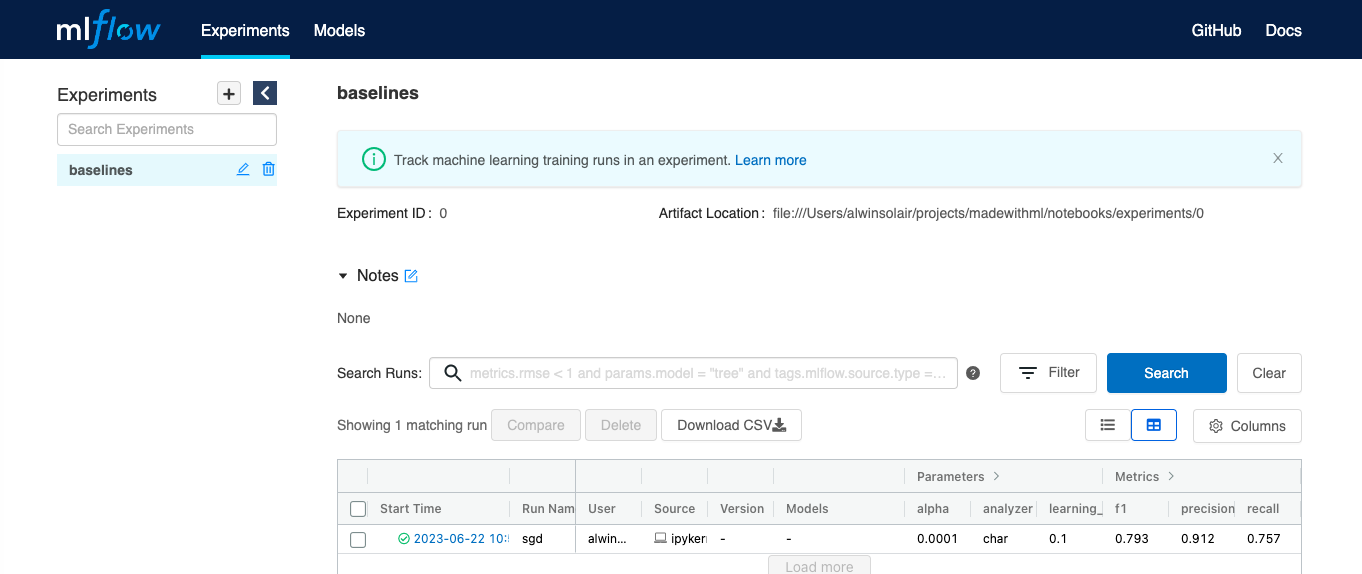

We can click on any of our experiments on the main dashboard to further explore it (click on the timestamp link for each run). Then click on metrics on the left side to view them in a plot:

#### Loading

We need to be able to load our saved experiment artifacts for inference, retraining, etc.

In [ ]:
def load_dict(filepath):
    """Load a dict from a json file."""
    with open(filepath, "r") as fp:
        d = json.load(fp)
    return d

In [ ]:
# Load all runs from experiment
experiment_id = mlflow.get_experiment_by_name("baselines").experiment_id
all_runs = mlflow.search_runs(experiment_ids=experiment_id, order_by=["metrics.val_loss ASC"])
print (all_runs)

In [ ]:
# Best run
best_run_id = all_runs.iloc[0].run_id
best_run = mlflow.get_run(run_id=best_run_id)
client = mlflow.tracking.MlflowClient()
with tempfile.TemporaryDirectory() as dp:
    client.download_artifacts(run_id=best_run_id, path="", dst_path=dp)
    vectorizer = joblib.load(Path(dp, "vectorizer.pkl"))
    label_encoder = LabelEncoder.load(fp=Path(dp, "label_encoder.json"))
    model = joblib.load(Path(dp, "model.pkl"))
    performance = load_dict(filepath=Path(dp, "performance.json"))


In [ ]:
print (json.dumps(performance, indent=2))

In [ ]:
# Inference
text = "Transfer learning with transformers for text classification."
predict_tag(texts=[text])

#### Optimization

Optimization is the process of fine-tuning the hyperparameters in our experiment to optimize towards a particular objective. It can be a computationally involved process depending on the number of parameters, search space and model architectures. Hyperparameters don't just include the model's parameters but they also include parameters (choices) from preprocessing, splitting, etc. When we look at all the different parameters that can be tuned, it quickly becomes a very large search space. However, just because something is a hyperparameter doesn't mean we need to tune it.

    It's absolutely alright to fix some hyperparameters 
    (ex. lower=True during preprocessing) and remove them from the current tuning subset. 
    Just be sure to note which parameters you are fixing and your reasoning for doing so.

    You can initially just tune a small, yet influential, subset of hyperparameters 
    that you believe will yield best results.

There are many options for hyperparameter tuning (Optuna, Ray tune, Hyperopt, etc.) but we'll be using Optuna for it's simplicity and efficiency.

In [ ]:
!pip install optuna==2.10.0 numpyencoder==0.3.0 -q

In [ ]:
import optuna

There are many factors to consider when performing hyperparameter optimization and luckily Optuna allows us to implement them with ease. We'll be conducting a small study where we'll tune a set of arguments (we'll do a much more thorough study of the parameter space when we move our code to Python scripts). Here's the process for the study:

1. Define an objective (metric) and identifying the direction to optimize.
2. OPTIONAL - Choose a sampler for determining parameters for subsequent trials. (default is a tree based sampler).
3. OPTIONAL - Choose a pruner to end unpromising trials early.
4. Define the parameters to tune in each trial and the distribution of values to sample.

We're going to use the same training function as before since we've added the functionality to prune a specific run if the trial argument is not None.

    # Pruning (inside train() function)
    trial.report(val_loss, epoch)
    if trial.should_prune():
        raise optuna.TrialPruned()

#### Objective

We need to define an objective function that will consume a trial and a set of arguments and produce the metric to optimize on (_f1_ in our case).

In [ ]:
def objective(args, trial):
    """Objective function for optimization trials."""
    # Parameters to tune
    args.analyzer = trial.suggest_categorical("analyzer", ["word", "char", "char_wb"])
    args.ngram_max_range = trial.suggest_int("ngram_max_range", 3, 10)
    args.learning_rate = trial.suggest_loguniform("learning_rate", 1e-2, 1e0)
    args.power_t = trial.suggest_uniform("power_t", 0.1, 0.5)

    # Train & evaluate
    artifacts = train(args=args, df=df, trial=trial)

    # Set additional attributes
    performance = artifacts["performance"]
    print(json.dumps(performance, indent=2))
    trial.set_user_attr("precision", performance["precision"])
    trial.set_user_attr("recall", performance["recall"])
    trial.set_user_attr("f1", performance["f1"])

    return performance["f1"]

#### Study

We're ready to kick off our study with our MLFlowCallback so we can track all of the different trials.

In [ ]:
from numpyencoder import NumpyEncoder
from optuna.integration.mlflow import MLflowCallback

In [ ]:
NUM_TRIALS = 20  # small sample for now

In [ ]:
# Optimize
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
study = optuna.create_study(study_name="optimization", direction="maximize", pruner=pruner)
mlflow_callback = MLflowCallback(
    tracking_uri=mlflow.get_tracking_uri(), metric_name="f1")
study.optimize(lambda trial: objective(args, trial),
            n_trials=NUM_TRIALS,
            callbacks=[mlflow_callback])

In [ ]:
# Uncomment the code below to generate a public URL
# get_ipython().system_raw("mlflow server -h 0.0.0.0 -p 8000 --backend-store-uri $PWD/experiments/ &")
# !npx localtunnel --port 8000

In [ ]:
1. Click on the "optimization" experiment on the left side under Experiments.
2. Select runs to compare by clicking on the toggle box to the left of each run or by clicking on the toggle box in the header to select all runs in this experiment.
3. Click on the Compare button.

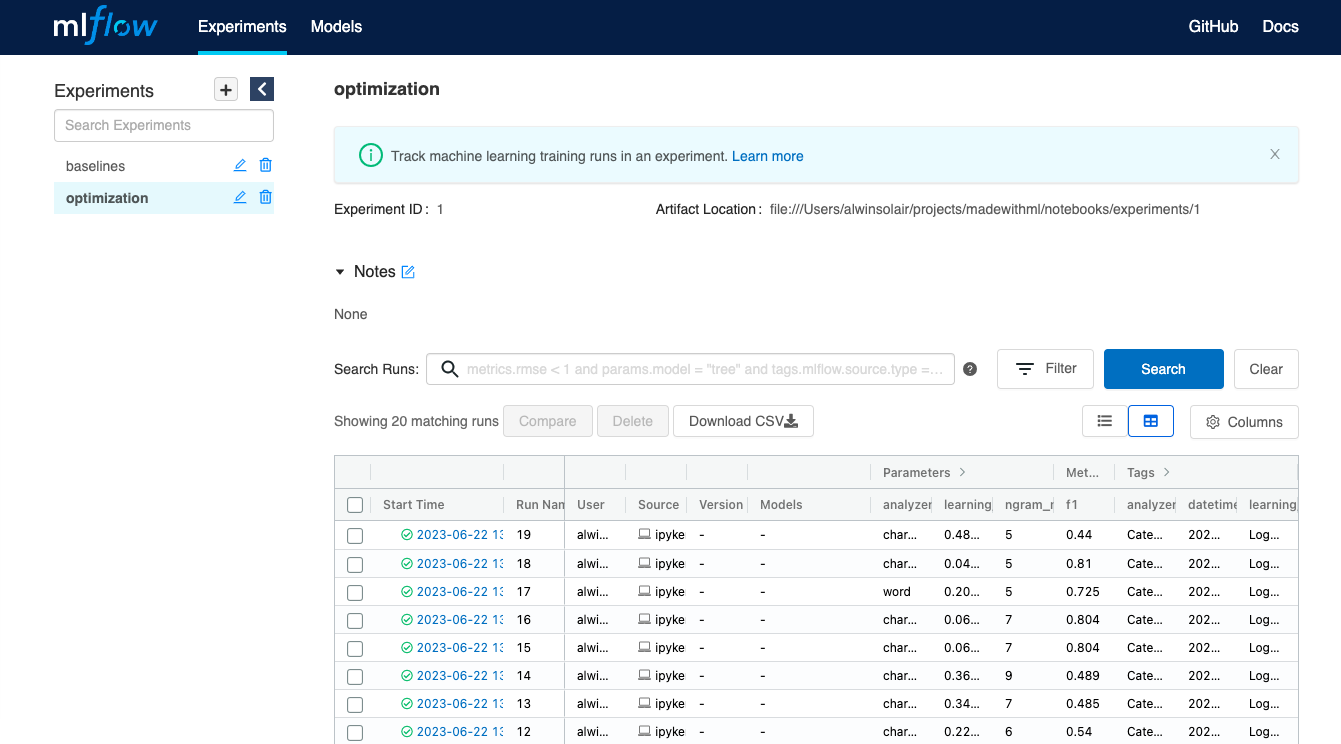

4. In the comparison page, we can then view the results through various lens (contours, parallel coordinates, etc.)

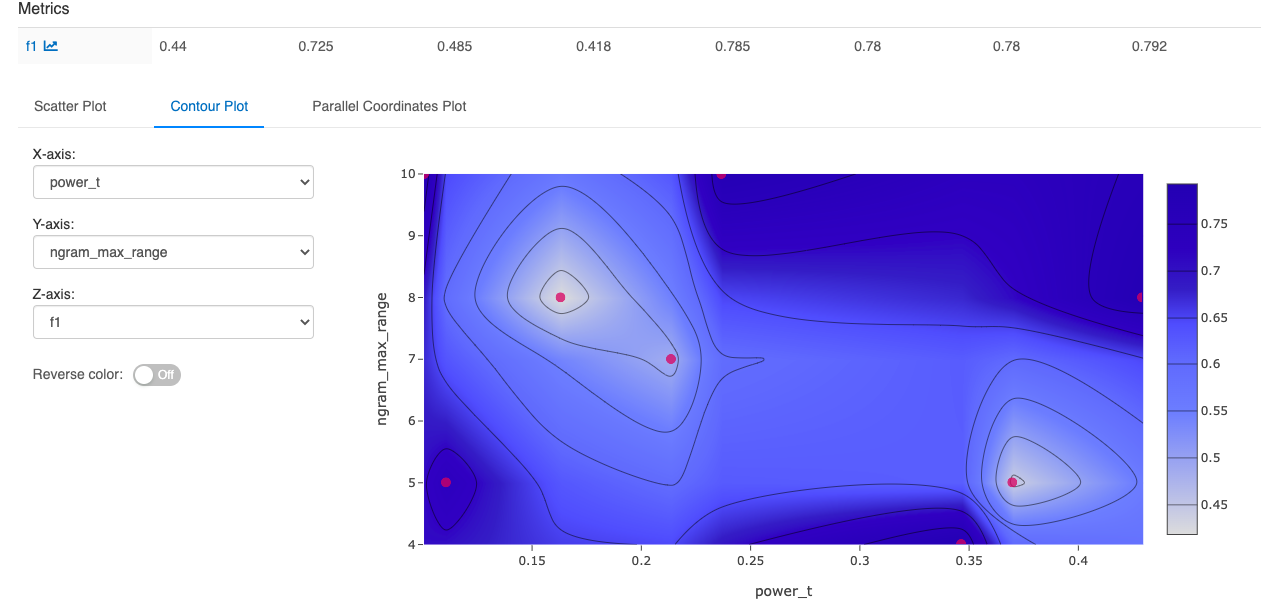

In [ ]:
# All trials
trials_df = study.trials_dataframe()
trials_df = trials_df.sort_values(["user_attrs_f1"], ascending=False)  # sort by metric
trials_df.head()

In [ ]:
# Best trial
print (f"Best value (f1): {study.best_trial.value}")
print (f"Best hyperparameters: {json.dumps(study.best_trial.params, indent=2)}")

In [ ]:
# Save best parameter values
args = {**args.__dict__, **study.best_trial.params}
print (json.dumps(args, indent=2, cls=NumpyEncoder))

... and now we're finally ready to move from working in Jupyter notebooks to Python scripts.

In [ ]:
# Clean up
!rm -rf experiments
!rm labeled_projects.csv